In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import ensemble
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score as auc
import time
import matplotlib.pyplot as plt
import xgboost as xgb



plt.rcParams['figure.figsize'] = (10, 10)

#%% load data and remove constant and duplicate columns  (taken from a kaggle script)

trainDataFrame = pd.read_csv('./data/train.csv')

# remove constant columns
colsToRemove = []
for col in trainDataFrame.columns:
    if trainDataFrame[col].std() == 0:
        colsToRemove.append(col)

trainDataFrame.drop(colsToRemove, axis=1, inplace=True)

# remove duplicate columns
colsToRemove = []
columns = trainDataFrame.columns
for i in range(len(columns)-1):
    v = trainDataFrame[columns[i]].values
    for j in range(i+1,len(columns)):
        if np.array_equal(v,trainDataFrame[columns[j]].values):
            colsToRemove.append(columns[j])

trainDataFrame.drop(colsToRemove, axis=1, inplace=True)

trainLabels = trainDataFrame['TARGET']
trainFeatures = trainDataFrame.drop(['ID','TARGET'], axis=1)


#%% look at single feature performance

X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(trainFeatures, trainLabels,
                                                                       test_size=0.5, random_state=1)

# verySimpleLearner = ensemble.GradientBoostingClassifier(n_estimators=20, max_features=1, max_depth=3,
#                                                         min_samples_leaf=100, learning_rate=0.1,
#                                                         subsample=0.65, loss='deviance', random_state=1)

verySimpleLearner = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=20,
                                subsample=0.6, seed=1234)


startTime = time.time()
singleFeatureTable = pd.DataFrame(index=range(len(X_train.columns)), columns=['feature','AUC'])
for k,feature in enumerate(X_train.columns):
    trainInputFeature = X_train[feature].values.reshape(-1,1)
    validInputFeature = X_valid[feature].values.reshape(-1,1)
    verySimpleLearner.fit(trainInputFeature, y_train)

    validAUC = auc(y_valid, verySimpleLearner.predict_proba(validInputFeature)[:,1])
    singleFeatureTable.ix[k,'feature'] = feature
    singleFeatureTable.ix[k,'AUC'] = validAUC

print("finished evaluating single features. took %.2f minutes" %((time.time()-startTime)/60))

#Show single feature AUC performace
singleFeatureTable = singleFeatureTable.sort_values(by='AUC', axis=0, ascending=False).reset_index(drop=True)
print(singleFeatureTable.ix[:130,:])





finished evaluating single features. took 0.60 minutes
                           feature       AUC
0                            var15  0.710024
1                      saldo_var30  0.709023
2                      saldo_var42  0.698961
3           saldo_medio_var5_hace2  0.694446
4                         num_var4  0.689323
5                        num_var35  0.689044
6            saldo_medio_var5_ult1  0.685155
7                       saldo_var5  0.683166
8              num_meses_var5_ult3  0.682985
9            saldo_medio_var5_ult3  0.678796
10                       num_var30  0.671296
11          saldo_medio_var5_hace3  0.664291
12                       ind_var30  0.663864
13                        num_var5  0.659115
14                        ind_var5  0.658915
15                       num_var42  0.657306
16                           var36  0.637493
17                           var38  0.593793
18        num_meses_var39_vig_ult3  0.552889
19                 num_var45_hace2  0.546129


In [2]:
#%% find interesting fivewise combinations

numFeaturesInCombination = 50
numCombinations = 500
numBestSingleFeaturesToSelectFrom = 100

X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(trainFeatures, trainLabels, 
                                                                       test_size=0.5, random_state=1)


#here to specify to look for two features only in the model building
# weakLearner = ensemble.GradientBoostingClassifier(n_estimators=30, max_features=2, max_depth=3, 
#                                                   min_samples_leaf=100,learning_rate=0.1, 
#                                                   subsample=0.65, loss='deviance', random_state=1)



weakLearner = xgb.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=50,
                                subsample=0.6, seed=1234)



featuresToUse = singleFeatureTable.ix[0:numBestSingleFeaturesToSelectFrom-1,'feature']
featureColumnNames = ['feature'+str(x+1) for x in range(numFeaturesInCombination)]
featureCombinationsTable = pd.DataFrame(index=range(numCombinations), columns=featureColumnNames + ['combinedAUC'])

# for numCombinations iterations 
startTime = time.time()
for combination in range(numCombinations):
    print(combination)
    # generate random feature combination
    randomSelectionOfFeatures = sorted(np.random.choice(len(featuresToUse), numFeaturesInCombination, replace=False))

    # store the feature names
    combinationFeatureNames = [featuresToUse[x] for x in randomSelectionOfFeatures]
    for i in range(len(randomSelectionOfFeatures)):
        featureCombinationsTable.ix[combination,featureColumnNames[i]] = combinationFeatureNames[i]

    # build features matrix to get the combination AUC
    trainInputFeatures = X_train.ix[:,combinationFeatureNames]
    validInputFeatures = X_valid.ix[:,combinationFeatureNames]
    # train learner
    weakLearner.fit(trainInputFeatures, y_train)
    # store AUC results
    validAUC = auc(y_valid, weakLearner.predict_proba(validInputFeatures)[:,1])        
    featureCombinationsTable.ix[combination,'combinedAUC'] = validAUC
    
    
validAUC = np.array(featureCombinationsTable.ix[:,'combinedAUC'])
print("(min,max) AUC = (%.4f,%.4f). took %.1f minutes" % (validAUC.min(),validAUC.max(), (time.time()-startTime)/60))






0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

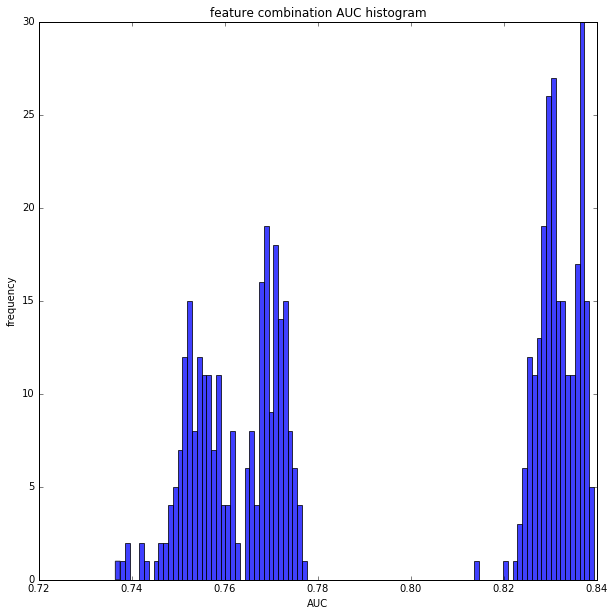

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,combinedAUC
0,var15,saldo_var30,saldo_var42,saldo_medio_var5_hace2,num_var35,saldo_medio_var5_ult1,num_meses_var5_ult3,num_var30,ind_var30,num_var5,...,num_op_var39_efect_ult1,num_aport_var13_hace3,num_op_var41_ult1,saldo_medio_var8_ult1,num_op_var39_ult1,ind_var14_0,ind_var10cte_ult1,ind_var26_cte,ind_var25_0,0.839364
1,var15,saldo_var30,saldo_var42,saldo_medio_var5_hace2,saldo_medio_var5_hace3,ind_var5,var38,num_var45_hace2,num_var30_0,num_med_var45_ult3,...,delta_imp_aport_var13_1y3,delta_num_aport_var13_1y3,saldo_medio_var8_ult1,ind_var10_ult1,ind_var9_ult1,ind_var10cte_ult1,ind_var25_cte,saldo_medio_var13_corto_hace3,ind_var25_0,0.838934
2,var15,saldo_var30,saldo_medio_var5_hace2,num_var4,num_var35,saldo_var5,num_meses_var5_ult3,saldo_medio_var5_ult3,num_var30,num_var42,...,imp_op_var41_efect_ult3,num_var22_ult3,ind_var8,saldo_var8,num_op_var41_ult1,ind_var10_ult1,ind_var14_0,ind_var9_cte_ult1,saldo_medio_var13_corto_hace3,0.838638
3,var15,saldo_var30,saldo_var42,saldo_medio_var5_hace2,num_var4,num_var35,saldo_var5,num_meses_var5_ult3,saldo_medio_var5_hace3,var38,...,imp_aport_var13_hace3,num_op_var41_ult1,saldo_medio_var8_ult1,num_op_var39_ult1,ind_var10_ult1,num_var14_0,ind_var25_cte,ind_var9_cte_ult1,ind_var25_0,0.838383
4,var15,saldo_var30,saldo_medio_var5_hace2,saldo_medio_var5_ult1,saldo_medio_var5_ult3,ind_var5,var38,num_meses_var39_vig_ult3,num_var45_ult1,ind_var41_0,...,saldo_medio_var8_ult1,saldo_medio_var8_hace2,ind_var14_0,num_var14_0,ind_var10cte_ult1,ind_var25_cte,ind_var9_cte_ult1,saldo_medio_var13_corto_hace3,ind_var25_0,0.838358
5,var15,saldo_var30,saldo_medio_var5_hace2,num_var35,saldo_medio_var5_ult1,saldo_medio_var5_hace3,ind_var5,num_var42,var38,num_var30_0,...,saldo_var8,num_op_var41_efect_ult1,num_op_var39_efect_ult1,num_op_var41_ult1,saldo_medio_var8_ult1,num_op_var39_ult1,ind_var9_ult1,ind_var25_cte,ind_var9_cte_ult1,0.838206
6,var15,saldo_var30,saldo_medio_var5_hace2,num_var35,saldo_var5,num_meses_var5_ult3,saldo_medio_var5_ult3,num_var30,num_var5,ind_var5,...,imp_aport_var13_hace3,num_aport_var13_hace3,delta_num_aport_var13_1y3,num_op_var41_ult1,num_op_var39_ult1,ind_var9_ult1,num_var14_0,ind_var9_cte_ult1,ind_var25_0,0.838122
7,var15,saldo_var30,saldo_var42,saldo_medio_var5_hace2,num_var4,saldo_medio_var5_ult1,saldo_var5,saldo_medio_var5_ult3,num_var30,saldo_medio_var5_hace3,...,delta_imp_aport_var13_1y3,saldo_medio_var8_ult1,ind_var10_ult1,saldo_medio_var8_hace2,ind_var9_ult1,num_var14_0,ind_var10cte_ult1,ind_var25_cte,ind_var9_cte_ult1,0.83809
8,var15,saldo_var30,saldo_medio_var5_hace2,num_var4,saldo_medio_var5_ult1,saldo_medio_var5_hace3,var38,num_meses_var39_vig_ult3,num_var45_hace2,num_var30_0,...,ind_var10_ult1,saldo_medio_var8_hace2,ind_var9_ult1,ind_var14_0,num_var14_0,ind_var10cte_ult1,ind_var25_cte,ind_var9_cte_ult1,ind_var25_0,0.838013
9,var15,saldo_var30,saldo_var42,saldo_medio_var5_ult1,saldo_var5,saldo_medio_var5_ult3,num_var30,saldo_medio_var5_hace3,ind_var30,num_var5,...,num_op_var39_efect_ult1,imp_aport_var13_hace3,delta_imp_aport_var13_1y3,saldo_medio_var8_ult1,ind_var10_ult1,ind_var9_ult1,ind_var14_0,ind_var10cte_ult1,ind_var26_cte,0.837986


In [3]:
# show the histogram of the feature combinations performance 
plt.figure(); plt.hist(validAUC, 100, facecolor='blue', alpha=0.75)
plt.xlabel('AUC'); plt.ylabel('frequency'); plt.title('feature combination AUC histogram'); plt.show()

featureCombinationsTable = featureCombinationsTable.sort_values(by='combinedAUC', axis=0, 
                                                                ascending=False).reset_index(drop=True)
featureCombinationsTable.ix[:20,:]


In [4]:

featureCombinationsTable = featureCombinationsTable.sort_values(by='combinedAUC', axis=0, 
                                                                ascending=False).reset_index(drop=True)
featureCombinationsTable.ix[:20,:]
filename="./data/featureCombination_raw.csv"
featureCombinationsTable.to_csv(filename, index=False)



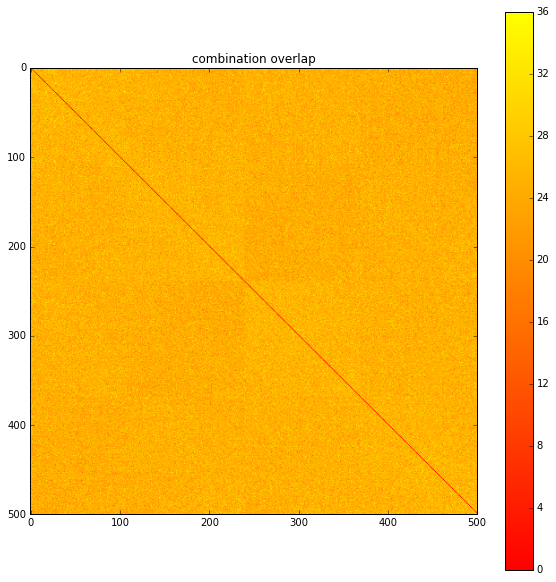

In [10]:
combinationOverlapMatrix = np.zeros((numCombinations,numCombinations))
for comb_i in range(numCombinations):
    for comb_j in range(comb_i+1,numCombinations):
        # get the features list for each combination        
        featuresComb_i = [featureCombinationsTable.ix[comb_i,featureColumnNames[x]] for x in range(numFeaturesInCombination)]
        featuresComb_j = [featureCombinationsTable.ix[comb_j,featureColumnNames[x]] for x in range(numFeaturesInCombination)]
        # store the number of overlapping features
        combinationOverlapMatrix[comb_i,comb_j] = 2*numFeaturesInCombination-len(set(featuresComb_i+featuresComb_j))
        #combinationOverlapMatrix[comb_i,comb_j] = len(set(featuresComb_i+featuresComb_j))
        combinationOverlapMatrix[comb_j,comb_i] = combinationOverlapMatrix[comb_i,comb_j]
        


plt.figure(); plt.imshow(combinationOverlapMatrix,cmap='autumn', vmin=0); plt.title('combination overlap'); plt.colorbar()

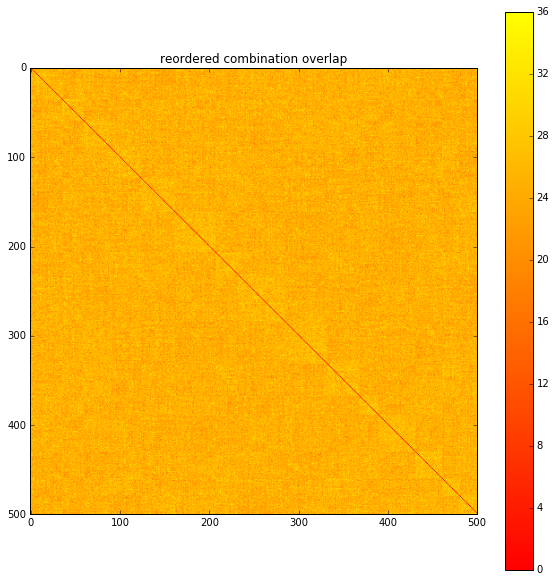

In [11]:
#Perform k-means on the overlap patterns and reorder the matrix

numFeaturesToSelect = 15

cluserer = cluster.KMeans(n_clusters=numFeaturesToSelect)
clusterInds = cluserer.fit_predict(combinationOverlapMatrix)

#%% reorder features according to their new clusters

# group the rows into clusters
clusteredRows = {}
clusterMaxAUC = {}
clusterMaxInd = {}
for clusterInd in np.unique(clusterInds):
    clusteredRows[clusterInd] = combinationOverlapMatrix[clusterInds == clusterInd,:]
    clusterMaxAUC[clusterInd] = featureCombinationsTable.ix[clusterInds == clusterInd,'combinedAUC'].max(axis=0)
    clusterMaxInd[clusterInd] = featureCombinationsTable.ix[clusterInds == clusterInd,'combinedAUC'].idxmax(axis=0)    
    
import operator    
sortedClustersByMaxAUCTuple = sorted(clusterMaxAUC.items(), key=operator.itemgetter(1),reverse=True)

# calculate the reordering vector
finalFeaturesToKeep = []
reorderedVector = None
for k,item in enumerate(sortedClustersByMaxAUCTuple):
    if k == 0:
        reorderedVector = np.array((clusterInds == item[0]).nonzero())

    else:
        reorderedVector = np.hstack((reorderedVector,np.array((clusterInds == item[0]).nonzero())))
    finalFeaturesToKeep.append(clusterMaxInd[item[0]])
    
reorderedVector = reorderedVector.flatten()

# reorder the matrix by rows and columns
reorderedMatrix = combinationOverlapMatrix[reorderedVector,:]
reorderedMatrix = reorderedMatrix[:,reorderedVector]

# show the matrix
plt.figure(); plt.imshow(reorderedMatrix,cmap='autumn', vmin=0); plt.title('reordered combination overlap'); plt.colorbar()



In [7]:
featureCombinationsTable.ix[finalFeaturesToKeep,:]

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,combinedAUC
0,var15,saldo_var30,saldo_var42,saldo_medio_var5_hace2,num_var35,saldo_medio_var5_ult1,num_meses_var5_ult3,num_var30,ind_var30,num_var5,...,num_op_var39_efect_ult1,num_aport_var13_hace3,num_op_var41_ult1,saldo_medio_var8_ult1,num_op_var39_ult1,ind_var14_0,ind_var10cte_ult1,ind_var26_cte,ind_var25_0,0.839364
1,var15,saldo_var30,saldo_var42,saldo_medio_var5_hace2,saldo_medio_var5_hace3,ind_var5,var38,num_var45_hace2,num_var30_0,num_med_var45_ult3,...,delta_imp_aport_var13_1y3,delta_num_aport_var13_1y3,saldo_medio_var8_ult1,ind_var10_ult1,ind_var9_ult1,ind_var10cte_ult1,ind_var25_cte,saldo_medio_var13_corto_hace3,ind_var25_0,0.838934
2,var15,saldo_var30,saldo_medio_var5_hace2,num_var4,num_var35,saldo_var5,num_meses_var5_ult3,saldo_medio_var5_ult3,num_var30,num_var42,...,imp_op_var41_efect_ult3,num_var22_ult3,ind_var8,saldo_var8,num_op_var41_ult1,ind_var10_ult1,ind_var14_0,ind_var9_cte_ult1,saldo_medio_var13_corto_hace3,0.838638
3,var15,saldo_var30,saldo_var42,saldo_medio_var5_hace2,num_var4,num_var35,saldo_var5,num_meses_var5_ult3,saldo_medio_var5_hace3,var38,...,imp_aport_var13_hace3,num_op_var41_ult1,saldo_medio_var8_ult1,num_op_var39_ult1,ind_var10_ult1,num_var14_0,ind_var25_cte,ind_var9_cte_ult1,ind_var25_0,0.838383
4,var15,saldo_var30,saldo_medio_var5_hace2,saldo_medio_var5_ult1,saldo_medio_var5_ult3,ind_var5,var38,num_meses_var39_vig_ult3,num_var45_ult1,ind_var41_0,...,saldo_medio_var8_ult1,saldo_medio_var8_hace2,ind_var14_0,num_var14_0,ind_var10cte_ult1,ind_var25_cte,ind_var9_cte_ult1,saldo_medio_var13_corto_hace3,ind_var25_0,0.838358
5,var15,saldo_var30,saldo_medio_var5_hace2,num_var35,saldo_medio_var5_ult1,saldo_medio_var5_hace3,ind_var5,num_var42,var38,num_var30_0,...,saldo_var8,num_op_var41_efect_ult1,num_op_var39_efect_ult1,num_op_var41_ult1,saldo_medio_var8_ult1,num_op_var39_ult1,ind_var9_ult1,ind_var25_cte,ind_var9_cte_ult1,0.838206
6,var15,saldo_var30,saldo_medio_var5_hace2,num_var35,saldo_var5,num_meses_var5_ult3,saldo_medio_var5_ult3,num_var30,num_var5,ind_var5,...,imp_aport_var13_hace3,num_aport_var13_hace3,delta_num_aport_var13_1y3,num_op_var41_ult1,num_op_var39_ult1,ind_var9_ult1,num_var14_0,ind_var9_cte_ult1,ind_var25_0,0.838122
9,var15,saldo_var30,saldo_var42,saldo_medio_var5_ult1,saldo_var5,saldo_medio_var5_ult3,num_var30,saldo_medio_var5_hace3,ind_var30,num_var5,...,num_op_var39_efect_ult1,imp_aport_var13_hace3,delta_imp_aport_var13_1y3,saldo_medio_var8_ult1,ind_var10_ult1,ind_var9_ult1,ind_var14_0,ind_var10cte_ult1,ind_var26_cte,0.837986
12,var15,saldo_var30,num_var4,num_var35,saldo_medio_var5_ult3,num_var30,ind_var5,num_var42,var38,num_var30_0,...,num_var22_hace2,num_op_var39_efect_ult1,imp_aport_var13_hace3,delta_num_aport_var13_1y3,num_op_var41_ult1,ind_var10_ult1,ind_var14_0,num_var14_0,ind_var25_0,0.837681
21,var15,saldo_var30,saldo_var42,saldo_medio_var5_hace2,ind_var5,var36,var38,num_var45_hace2,num_var30_0,num_med_var45_ult3,...,num_op_var41_ult1,saldo_medio_var8_ult1,num_op_var39_ult1,ind_var10_ult1,saldo_medio_var8_hace2,ind_var9_ult1,num_var14_0,saldo_medio_var13_corto_hace3,ind_var25_0,0.837264


In [8]:
feature_tokeep=featureCombinationsTable.ix[finalFeaturesToKeep,:]

filename="./data/featureCombination_selection.csv"
feature_tokeep.to_csv(filename, index=False)


In [9]:
combinationOverlapMatrix[0,1:].max()

31.0